## 自动求导


自动求导
假设我们想对函数 y=2x⊤x关于列向量 x求导

In [ ]:
import torch 

x = torch.arange(4.0)
x

tensor([0., 1., 2., 3.])

In [ ]:
x.requires_grad_(True)
x.grad

In [ ]:
y = 2 * torch.dot(x,x)
y

tensor(28., grad_fn=<MulBackward0>)

In [ ]:
y.backward()
x.grad

tensor([ 0.,  4.,  8., 12.])

In [ ]:
x.grad == 4*x

tensor([True, True, True, True])

In [ ]:
x.grad.zero_()
y = x.sum()
y.backward()
x.grad

tensor([1., 1., 1., 1.])

In [ ]:
x.grad.zero_()
y = x*x

# y.backward(torch.ones(len(y)))
y.sum().backward()
x.grad

tensor([0., 2., 4., 6.])

### 将某些计算移动到记录的计算图之外

In [ ]:
x.grad.zero_()
y = x * x
u = y.detach()
z = u * x
print(z.requires_grad)
z.sum().backward()
x.grad == u

True


tensor([True, True, True, True])

In [ ]:
x.grad.zero_()
y.sum().backward()
x.grad == 2*x

tensor([True, True, True, True])

### 即使构建函数的计算图需要通过 Python控制流（例如，条件、循环或任意函数调用），我们仍然可以计算得到的变量的梯度

In [ ]:
def f(a):
  b = a * 2
  while b.norm() < 1000:
    b = b*2
  if b.sum()>0:
    c = b
  else:
    c = 100 * b
  return c

a = torch.randn(size=(),requires_grad=True)
d = f(a)
d.backward()

a.grad == d/a

tensor(True)

## 线性回归的从零开始实现

In [ ]:
!pip install d2l

     |████████████████████████████████| 81kB 3.8MB/s 


In [64]:
%matplotlib inline
import random
import torch 
from d2l import torch as d2l

In [32]:
torch.normal(0,0.01,(3,3))

tensor([[ 0.0153,  0.0019, -0.0033],
        [ 0.0223,  0.0087,  0.0109],
        [ 0.0156,  0.0049,  0.0060]])

In [33]:
def synthetic_data(w,b,num_examples):
  X = torch.normal(0,1,(num_examples,len(w)))
  y = torch.matmul(X,w) + b
  y += torch.normal(0,0.01,y.shape)
  return X,y.reshape((-1,1))

true_w = torch.tensor([2,-3.4])
print(true_w.shape)
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

torch.Size([2])


In [37]:
print('features:',features[0],'\nlabel:',labels[0])

features: tensor([ 0.6404, -0.1446]) 
label: tensor([5.9680])


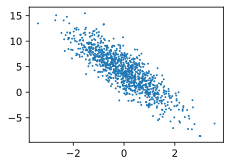

In [36]:
d2l.set_figsize()
d2l.plt.scatter(features[:, (1)].detach().numpy(),
                labels.detach().numpy(), 1)

In [65]:
def data_iter(batch_size, features, labels):
  num_examples = len(features)
  indices = list(range(num_examples))
  random.shuffle(indices)
  for i in range(0, num_examples, batch_size):
    batch_indices = torch.tensor(indices[i:min(i+batch_size,num_examples)])

    yield features[batch_indices], labels[batch_indices]

batch_size = 10

for X,y in data_iter(batch_size,features,labels):
  print(X,'\n',y)
  break

tensor([[-1.5952,  0.8766],
        [ 1.0412,  0.6261],
        [ 0.4468,  0.1595],
        [-0.3620,  0.3939],
        [ 0.2286,  0.1683],
        [-0.7206,  0.2128],
        [ 0.7955,  0.1584],
        [ 1.0568,  1.1237],
        [ 0.0522, -1.2163],
        [-0.4797, -0.1424]]) 
 tensor([[-1.9569],
        [ 4.1737],
        [ 4.5612],
        [ 2.1187],
        [ 4.1058],
        [ 2.0276],
        [ 5.2435],
        [ 2.4989],
        [ 8.4409],
        [ 3.7405]])


### 定义 初始化模型参数

In [66]:
w = torch.normal(0,0.01,size=(2,1), requires_grad=True)
b = torch.zeros(1,requires_grad = True)

In [78]:
def linreg(X,w,b):
  return torch.matmul(X,w)+b

In [79]:
def squared_loss(y_hat,y):
  return (y_hat - y.reshape(y_hat.shape))**2 / 2

In [80]:
def sgd(params,lr,batch_size):
  with torch.no_grad():
    for param in params:
      param -= lr * param.grad / batch_size
      param.grad.zero_()


In [86]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
  for X,y in data_iter(batch_size,features,labels):
    l = loss(net(X,w,b),y)
    l.sum().backward()
    sgd([w,b], lr, batch_size)
    
  with torch.no_grad():
    train_l = loss(net(features,w,b), labels)
    print(f'epoch {epoch+1},loss {float(train_l.mean()):f}')

epoch 1,loss 0.000051
epoch 2,loss 0.000051
epoch 3,loss 0.000051


In [73]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([-0.0003,  0.0002], grad_fn=<SubBackward0>)
b的估计误差: tensor([-0.0002], grad_fn=<RsubBackward1>)


## 探索Python中的引用传递与值传递
* 对象变量 引用传递
* int float bool 值传递

In [91]:
class stu:
  i = 1
  def __init__(self):
    self.age = 0
  

In [92]:

def change(listv,objv,intv):
  listv[0]=999
  objv.age = 888
  intv = 777

In [97]:
listv = [1,2]
objv = stu()
intv = 2
change(listv,objv,intv)


In [98]:
listv

[999, 2]

In [99]:
objv.age

888

In [100]:
intv

2